In [1]:
# Import libraries
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import os
import time

# from google.colab import drive
# drive.mount('/content/drive')

## I. Parse Text Sources
First we'll load our text sources and create our vocabulary lists and encoders.

There are ways we could do this in pure python, but using the tensorflow data structures and libraries allow us to keep things super-optimized.

In [2]:
# Load file data
path_to_file = tf.keras.utils.get_file('narnia.txt', 'https://raw.githubusercontent.com/Makayla417/mw_portfolio/main/narnia.txt')

# Read the content of the downloaded file
with open(path_to_file, 'r', encoding='utf-8') as file:
    text = file.read()

# Print the length of the text
print('Length of text: {} characters'.format(len(text)))

1342444/1342444 [==============================] - 0s 0us/step
Length of text: 1283652 characters


In [3]:
# Verify the first part of our data
print(text[-500:-1])

 so used to quarrelling and making it up again that they got married so as to 
go on doing it more conveniently. And after King Lune’s death they made a 
good King and Queen of Archenland and Ram the Great, the most famous of all 
the kings of Archenland, was their son. Bree and Hwin lived happily to a great 
age in Narnia and both got married but not to one another. And there weren’t 
many months in which one or both of them didn’t come trotting over the pass to 
visit their friends at Anvard.


In [4]:
# Now we'll get a list of the unique characters in the file. This will form the
# vocabulary of our network. There may be some characters we want to remove from this
# set as we refine the network.
vocab = sorted(set(text))
print('{} unique characters'.format(len(vocab)))
print(vocab)

84 unique characters
['\n', ' ', '!', '"', '#', "'", '(', ')', '*', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '^', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '¬', '°', '‘', '’', '“', '”']


In [5]:
# Next, we'll encode encode these characters into numbers so we can use them
# with our neural network, then we'll create some mappings between the characters
# and their numeric representations
ids_from_chars = preprocessing.StringLookup(vocabulary=list(vocab))
chars_from_ids = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=ids_from_chars.get_vocabulary(), invert=True)

# Here's a little helper function that we can use to turn a sequence of ids
# back into a string:
# turn them into a string:
def text_from_ids(ids):
  joinedTensor = tf.strings.reduce_join(chars_from_ids(ids), axis=-1)
  return joinedTensor.numpy().decode("utf-8")

In [6]:
# Now we'll verify that they work, by getting the code for "A", and then looking
# that up in reverse
testids = ids_from_chars(["T", "r", "u", "t", "h"])
testids

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([45, 70, 73, 72, 60])>

In [7]:
chars_from_ids(testids)

<tf.Tensor: shape=(5,), dtype=string, numpy=array([b'T', b'r', b'u', b't', b'h'], dtype=object)>

In [8]:
testString = text_from_ids( testids )
testString

'Truth'

## II. Construct our training data
Next we need to construct our training data by building sentence chunks. Each chunk will consist of a sequence of characters and a corresponding "next sequence" of the same length showing what would happen if we move forward in the text. This "next sequence" becomes our target variable.

For example, if this were our text:

> It is a truth universally acknowledged, that a single man in possession
of a good fortune, must be in want of a wife.

And our sequence length was 10 with a step size of 1, our first chunk would be:

* Sequence: `It is a tr`
* Next Sequence: `t is a tru`

Our second chunk would be:

* Sequence: `t is a tru`
* Next Word: ` is a trut`



In [9]:
# First, create a stream of encoded integers from our text
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1283652,), dtype=int64, numpy=array([39, 53, 70, ..., 56, 12,  2])>

In [10]:
# Now, convert that into a tensorflow dataset
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [11]:
# Finally, let's batch these sequences up into chunks for our training
seq_length = 100
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

# This function will generate our sequence pairs:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

# Call the function for every sequence in our list to create a new dataset
# of input->target pairs
dataset = sequences.map(split_input_target)

In [12]:
# Verify the dataset shape
for input_example_batch, target_example_batch in dataset.take(1):
    print("Input shape:", input_example_batch.shape)   # Should be (batch_size, seq_length-1)
    print("Target shape:", target_example_batch.shape) # Should be (batch_size, seq_length-1)

Input shape: (100,)
Target shape: (100,)


In [13]:
# Verify our sequences
for input_example, target_example in  dataset.take(1):
    print("Input: ", text_from_ids(input_example))
    print("--------")
    print("Target: ", text_from_ids(target_example))

Input:  Narnia 1 - The Lion, The Witch and The Wardrobe 

CHAPTER ONE 

LUCY LOOKS INTO A WARDROBE 

ONCE th
--------
Target:  arnia 1 - The Lion, The Witch and The Wardrobe 

CHAPTER ONE 

LUCY LOOKS INTO A WARDROBE 

ONCE the


In [14]:
# Finally, we'll randomize the sequences so that we don't just memorize the books
# in the order they were written, then build a new streaming dataset from that.
# Using a streaming dataset allows us to pass the data to our network bit by bit,
# rather than keeping it all in memory. We'll set it to figure out how much data
# to prefetch in the background.

BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

In [15]:
# Verify the dataset shape
for input_example_batch, target_example_batch in dataset.take(1):
    print("Input shape:", input_example_batch.shape)   # Should be (batch_size, seq_length-1)
    print("Target shape:", target_example_batch.shape) # Should be (batch_size, seq_length-1)

Input shape: (64, 100)
Target shape: (64, 100)


## III. Build the model

Next, we'll build our model. Up until this point, you've been using the Keras symbolic, or imperative API for creating your models. Doing something like:

    model = tf.keras.models.Sequentla()
    model.add(tf.keras.layers.Dense(80, activation='relu))
    etc...

However, tensorflow has another way to build models called the Functional API, which gives us a lot more control over what happens inside the model. You can read more about [the differences and when to use each here](https://blog.tensorflow.org/2019/01/what-are-symbolic-and-imperative-apis.html).

We'll use the functional API for our RNN in this example. This will involve defining our model as a custom subclass of `tf.keras.Model`.

If you're not familiar with classes in python, you might want to review [this quick tutorial](https://www.w3schools.com/python/python_classes.asp), as well as [this one on class inheritance](https://www.w3schools.com/python/python_inheritance.asp).

Using a functional model is important for our situation because we're not just training it to predict a single character for a single sequence, but as we make predictions with it, we need it to remember those predictions as use that memory as it makes new predictions.


In [16]:
# Create our custom model. Given a sequence of characters, this
# model's job is to predict what character should come next.
class AustenTextModel(tf.keras.Model):

  # This is our class constructor method, it will be executed when
  # we first create an instance of the class
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)

    # Our model will have three layers:

    # 1. An embedding layer that handles the encoding of our vocabulary into
    #    a vector of values suitable for a neural network
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

    # 2. An LSTM layer that handles the "memory" aspects of our RNN.
    self.lstm = tf.keras.layers.LSTM(rnn_units, return_sequences=True, return_state=True,
                                     recurrent_initializer='glorot_uniform',
                                     bias_initializer=tf.keras.initializers.Constant(1.0))

    # 3. Our output layer that will give us a set of probabilities for each
    #    character in our vocabulary.
    self.dense = tf.keras.layers.Dense(vocab_size)

  # This function will be executed for each epoch of our training. Here
  # we will manually feed information from one layer of our network to the
  # next.
  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs

    # 1. Feed the inputs into the embedding layer, and tell it if we are
    #    training or predicting
    x = self.embedding(x, training=training)

    # 2. If we don't have any state in memory yet, get the initial random state
    #    from our LSTM layer.
    if states is None:
      states = self.lstm.get_initial_state(x)

    # 3. Now, feed the vectorized input along with the current state of memory
    #    into the LSTM layer.
    x, h_state, c_state = self.lstm(x, initial_state=states, training=training)

    # 4. Finally, pass the results on to the dense layer
    x = self.dense(x, training=training)

    # 5. Return the results
    if return_state:
      return x, [h_state, c_state]
    else:
      return x


In [17]:
# Create an instance of our model
vocab_size=len(ids_from_chars.get_vocabulary())
embedding_dim = 256
rnn_units = 1024

# Switch comment to choose which model to use
model = AustenTextModel(vocab_size, embedding_dim, rnn_units)

In [18]:
# Verify the output of our model is correct by running one sample through
# This will also compile the model for us. This step will take a bit.
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")


(64, 100, 85) # (batch_size, sequence_length, vocab_size)


In [19]:
# Now let's view the model summary
model.summary()

Model: "austen_text_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  21760     
                                                                 
 lstm (LSTM)                 multiple                  5246976   
                                                                 
 dense (Dense)               multiple                  87125     
                                                                 
Total params: 5355861 (20.43 MB)
Trainable params: 5355861 (20.43 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## IV. Train the model

For our purposes, we'll be using [categorical cross entropy](https://machinelearningmastery.com/cross-entropy-for-machine-learning/) as our loss function*. Also, our model will be outputting ["logits" rather than normalized probabilities](https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow), because we'll be doing further transformations on the output later.


\* Note that since our model deals with integer encoding rather than one-hot encoding, we'll specifically be using [sparse categorical cross entropy](https://stats.stackexchange.com/questions/326065/cross-entropy-vs-sparse-cross-entropy-when-to-use-one-over-the-other).

In [20]:
# Define the path where you want to save your model
save_path = '/content/drive/My Drive/Narnia_LSTM_checkpoints/'

# Create the directory if it doesn't exist
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Define the checkpoint callback to save every 5 epochs
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(save_path, 'Narnia_LSTM_epoch_{epoch:02d}.h5'),
    save_weights_only=True,
    monitor='loss',
    save_freq=5 * len(dataset),  # Save every 5 epochs
    save_best_only=True
)

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='loss',
    patience=3,       # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Define the ReduceLROnPlateau callback
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=2,  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6  # Minimum learning rate
)

# Define the loss and optimizer with a specified learning rate
learning_rate = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

# Initialize the model
model = AustenTextModel(vocab_size, embedding_dim=256, rnn_units=1024)
model.compile(optimizer=optimizer, loss=loss)

# Train the model
history = model.fit(dataset,
                    epochs=30,
                    callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback])


Epoch 1/30
198/198 [==============================] - 25s 75ms/step - loss: 3.0628 - lr: 1.0000e-04
Epoch 2/30
198/198 [==============================] - 17s 73ms/step - loss: 2.5325 - lr: 1.0000e-04
Epoch 3/30
198/198 [==============================] - 17s 77ms/step - loss: 2.3072 - lr: 1.0000e-04
Epoch 4/30
198/198 [==============================] - 17s 73ms/step - loss: 2.1769 - lr: 1.0000e-04
Epoch 5/30
198/198 [==============================] - 16s 73ms/step - loss: 2.0764 - lr: 1.0000e-04
Epoch 6/30
198/198 [==============================] - 17s 72ms/step - loss: 1.9940 - lr: 1.0000e-04
Epoch 7/30
198/198 [==============================] - 17s 73ms/step - loss: 1.9234 - lr: 1.0000e-04
Epoch 8/30
198/198 [==============================] - 16s 73ms/step - loss: 1.8631 - lr: 1.0000e-04
Epoch 9/30
198/198 [==============================] - 16s 73ms/step - loss: 1.8105 - lr: 1.0000e-04
Epoch 10/30
198/198 [==============================] - 16s 73ms/step - loss: 1.7638 - lr: 1.0000e-04

In [21]:
# Recreate the model
# model = AustenTextModel(vocab_size, embedding_dim, rnn_units)
# # Load the weights
# model.load_weights('/content/drive/My Drive/Narnia_LSTM_checkpoints/Narnia_LSTM_epoch_30.h5')

## V. Use the model

Now that our model has been trained, we can use it to generate text. As mentioned earlier, to do so we have to keep track of its internal state, or memory, so that we can use previous text predictions to inform later ones.

However, with RNN generated text, if we always just pick the character with the highest probability, our model tends to get stuck in a loop. So instead we will create a probability distribution of characters for each step, and then sample from that distribution. We can add some variation to this using a paramter known as ["temperature"](https://cs.stackexchange.com/questions/79241/what-is-temperature-in-lstm-and-neural-networks-generally).

In [22]:
# Here's the code we'll use to sample for us. It has some extra steps to apply
# the temperature to the distribution, and to make sure we don't get empty
# characters in our text. Most importantly, it will keep track of our model
# state for us.

class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature=temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "" or "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['','[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices = skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask,validate_indices=False)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states =  self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature

    # Apply the prediction mask: prevent "" or "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Return the characters and model state.
    return chars_from_ids(predicted_ids), states


In [23]:
# Create an instance of the character generator
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

# Now, let's generate a 1000 character chapter by giving our model "The world seemed like such a peaceful place until the magic tree was discovered in London."
# as its starting text
states = None
next_char = tf.constant(['The world seemed like such a peaceful place until the magic tree was discovered in London.'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)

# Print the results formatted.
print(result[0].numpy().decode('utf-8'))




The world seemed like such a peaceful place until the magic tree was discovered in London. Bit 
that meanin: Edmund Sudmunh like plucy. We pleaved by edeminge than heme behord them a 
squitter. They were noise friend himsalles, up to the rest tost (more more pacry inxovercable kid 
flastyon. Scrubt when the Marsh, walked into the pain and wich the otce swoeld enough the 
shouldes fore people now anything; and loedndy which he keep, there is almost a moment. “And when 
will?” 

Edmund dregged stairaggenter, whow they could one had been here cloping ups at 

Caspaian, croubbed Digaz and Lucy. 

It was ale any forgats and about side of the brughes. Chiall 
himped the Queens - a Narnia. I’ve jobling front of branch, Nortar on two where 
they’re light.” 

At - come forte- in ploeriteat thrue place. Then she made on wonly, not 
hurther thing there was only the mopting. Stozing this toutheyeally 
flother, seemed it. How loses small up her fucy say, inginncouns feolm! 

The rasned mourthing fo

## VI. Next Steps

This is a very simple model with one GRU layer and then an output layer. However, considering how simple it is and the fact that we are predicting outputs character by character, the text it produces is pretty amazing. Though it still has a long way to go before publication.

There are many other RNN architectures you could try, such as adding additional hidden dense layers, replacing GRU with one or more LSTM layers, combining GRU and LSTM, etc...

You could also experiment with better text cleanup to make sure odd punctuation doesn't appear, or finding longer texts to use. If you combine texts from two authors, what happens? Can you generate a Jane Austen stageplay by combining austen and shakespeare texts?

Finally, there are a number of hyperparameters to tweak, such as temperature, epochs, batch size, sequence length, etc...

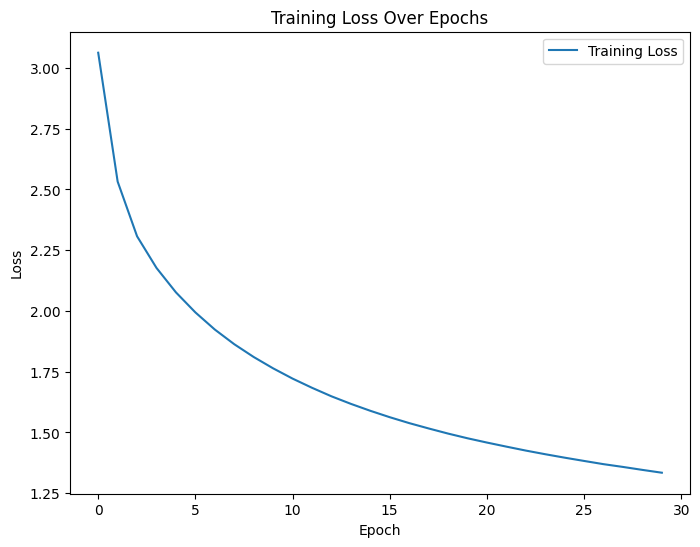

In [24]:
# Import Matplotlib for visualization
import matplotlib.pyplot as plt

# Plot training loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()